In [27]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score

In [28]:
# Define data transformations with data augmentation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(0.2),
        transforms.RandomApply([transforms.ColorJitter()], p=0.5),
        transforms.RandomAdjustSharpness(2, p=0.5),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

data_dir = 'D:/exam/TrashNet/'

# Load dataset with transformations
dataset = datasets.ImageFolder(root=data_dir, transform=data_transforms['train'])

# Split dataset
train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Apply the validation transformations to val and test datasets
val_dataset.dataset.transform = data_transforms['val']
test_dataset.dataset.transform = data_transforms['val']

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=4)

# Check the split sizes
print(f'Train size: {train_size}, Validation size: {val_size}, Test size: {test_size}')

# Get class names from the original dataset
class_names = dataset.classes
num_classes = len(class_names)
print(f'Class names: {class_names}, Number of classes: {num_classes}')

Train size: 2021, Validation size: 252, Test size: 254
Class names: ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash'], Number of classes: 6


In [29]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Define the model
model = models.vgg16(pretrained=True)
for param in model.features.parameters():
    param.requires_grad = False

# Replace the classifier part of the model with regularization
model.classifier[6] = nn.Sequential(
    nn.Linear(model.classifier[6].in_features, 1024),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(1024, 1024),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(1024, num_classes)
)
model = model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=0.0001, weight_decay=0.01)

# Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.2, patience=5, min_lr=0.00001)


# Training the model
num_epochs = 10
best_model_wts = model.state_dict()
best_acc = 0.0

train_loss_history = []
val_loss_history = []
train_acc_history = []
val_acc_history = []

for epoch in range(num_epochs):
    print('Epoch {}/{}'.format(epoch+1, num_epochs))
    print('-' * 10)

    # Each epoch has a training and validation phase
    for phase in ['train', 'val']:
        if phase == 'train':
            model.train()  # Set model to training mode
            dataloader = train_loader
        else:
            model.eval()   # Set model to evaluate mode
            dataloader = val_loader

        running_loss = 0.0
        running_corrects = 0

        # Iterate over data.
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward
            # Track history if only in train
            with torch.set_grad_enabled(phase == 'train'):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                # Backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            # Statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(dataloader.dataset)
        epoch_acc = running_corrects.double() / len(dataloader.dataset)

        print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

        # Deep copy the model
        if phase == 'val' and epoch_acc > best_acc:
            best_acc = epoch_acc
            best_model_wts = model.state_dict()

        # Save training and validation loss and accuracy
        if phase == 'train':
            train_loss_history.append(epoch_loss)
            train_acc_history.append(epoch_acc.cpu().numpy())  # Move to CPU and convert to numpy
        else:
            val_loss_history.append(epoch_loss)
            val_acc_history.append(epoch_acc.cpu().numpy())  # Move to CPU and convert to numpy

    # Step the scheduler
    scheduler.step(epoch_loss)

# Load best model weights
model.load_state_dict(best_model_wts)

Epoch 1/10
----------
train Loss: 0.9849 Acc: 0.6051
val Loss: 0.6773 Acc: 0.7460
Epoch 2/10
----------
train Loss: 0.4647 Acc: 0.8367
val Loss: 0.6046 Acc: 0.7857
Epoch 3/10
----------
train Loss: 0.2140 Acc: 0.9213
val Loss: 0.5838 Acc: 0.7897
Epoch 4/10
----------
train Loss: 0.1814 Acc: 0.9377
val Loss: 0.7001 Acc: 0.8095
Epoch 5/10
----------
train Loss: 0.1123 Acc: 0.9664
val Loss: 0.6669 Acc: 0.8214
Epoch 6/10
----------
train Loss: 0.0962 Acc: 0.9683
val Loss: 0.8340 Acc: 0.7817
Epoch 7/10
----------
train Loss: 0.1107 Acc: 0.9659
val Loss: 1.0813 Acc: 0.6825
Epoch 8/10
----------
train Loss: 0.1186 Acc: 0.9609
val Loss: 0.7266 Acc: 0.7778
Epoch 9/10
----------
train Loss: 0.0851 Acc: 0.9767
val Loss: 0.8387 Acc: 0.7579
Epoch 10/10
----------
train Loss: 0.0422 Acc: 0.9891
val Loss: 0.6367 Acc: 0.8175


<All keys matched successfully>

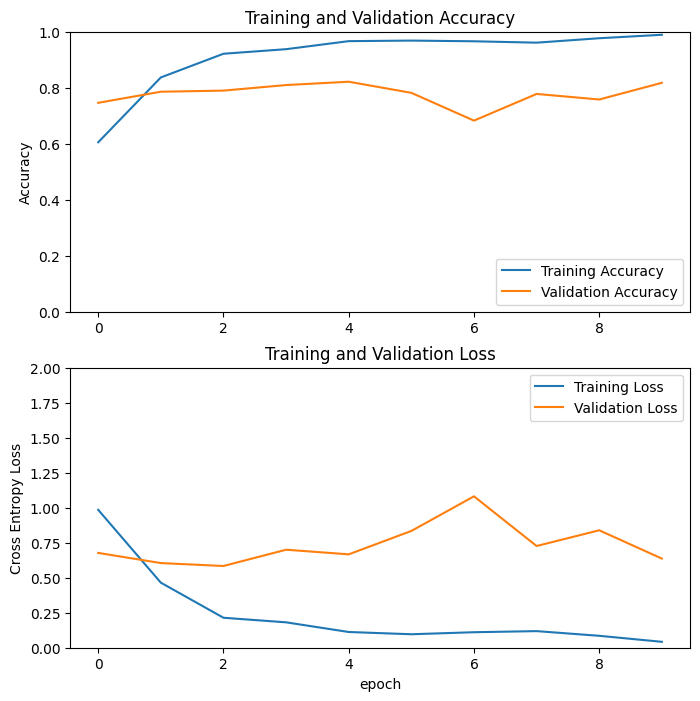

In [30]:
# Plot training and validation accuracy and loss
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(train_acc_history, label='Training Accuracy')
plt.plot(val_acc_history, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([0, 1.0])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(train_loss_history, label='Training Loss')
plt.plot(val_loss_history, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy Loss')
plt.ylim([0, 2.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [31]:
# Evaluate on the test set
model.eval()
test_loss = 0.0
test_corrects = 0

y_true = []
y_pred = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)
        test_loss += loss.item() * inputs.size(0)
        test_corrects += torch.sum(preds == labels.data)
        
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

test_loss = test_loss / len(test_loader.dataset)
test_acc = test_corrects.double() / len(test_loader.dataset)

print('Test Loss: {:.4f} Test Acc: {:.4f}'.format(test_loss, test_acc))

# Calculate precision, recall, f1-score
print('Test Precision:', precision_score(y_true, y_pred, average='weighted'))
print('Test Recall:', recall_score(y_true, y_pred, average='weighted'))
print('Test F1 Score:', f1_score(y_true, y_pred, average='weighted'))

Test Loss: 0.5631 Test Acc: 0.8504
Test Precision: 0.8536317493487049
Test Recall: 0.8503937007874016
Test F1 Score: 0.8491704662843784
